In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Floodnet'

/content/drive/MyDrive/Floodnet


In [ ]:
import os


train_images_dir = os.path.join('train', 'images')
train_masks_dir = os.path.join('train', 'masks')
val_images_dir = os.path.join('val', 'images')
val_masks_dir = os.path.join('val', 'masks')


def count_files(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])


train_images_count = count_files(train_images_dir)
train_masks_count = count_files(train_masks_dir)
val_images_count = count_files(val_images_dir)
val_masks_count = count_files(val_masks_dir)


print(f"Number of files in {train_images_dir}: {train_images_count}")
print(f"Number of files in {train_masks_dir}: {train_masks_count}")
print(f"Number of files in {val_images_dir}: {val_images_count}")
print(f"Number of files in {val_masks_dir}: {val_masks_count}")


Number of files in train/images: 2603
Number of files in train/masks: 2603
Number of files in val/images: 867
Number of files in val/masks: 867


In [ ]:
train_images_dir = 'train/images'
train_masks_dir = 'train/masks'
val_images_dir = 'val/images'
val_masks_dir = 'val/masks'

In [ ]:
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images and masks
def preprocess_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []

    # Get list of filenames from directory
    file_names = os.listdir(image_dir)

    for filename in file_names:
        # Load image and mask
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_lab.png'))  # Adjust mask filename

        image = load_img(image_path)   # Load and resize image
        mask = load_img(mask_path, color_mode='grayscale')  # Load and resize mask

        # Convert images and masks to numpy arrays and normalize
        image_array = img_to_array(image) / 255.0
        mask_array = img_to_array(mask)

        images.append(image_array)
        masks.append(mask_array)

    return np.array(images), np.array(masks)

In [ ]:
train_images, train_masks = preprocess_images_and_masks(train_images_dir, train_masks_dir)
np.save('train_images.npy', train_images)
np.save('train_masks.npy', train_masks)


val_images, val_masks = preprocess_images_and_masks(val_images_dir, val_masks_dir)
np.save('val_images.npy', val_images)
np.save('val_masks.npy', val_masks)

print(f"Training images shape: {train_images.shape}, dtype: {train_images.dtype}")
print(f"Training masks shape: {train_masks.shape}, dtype: {train_masks.dtype}")
print(f"Validation images shape: {val_images.shape}, dtype: {val_images.dtype}")
print(f"Validation masks shape: {val_masks.shape}, dtype: {val_masks.dtype}")

Loaded training images shape: (2603, 512, 512, 3), dtype: float32
Loaded training masks shape: (2603, 512, 512, 1), dtype: float32


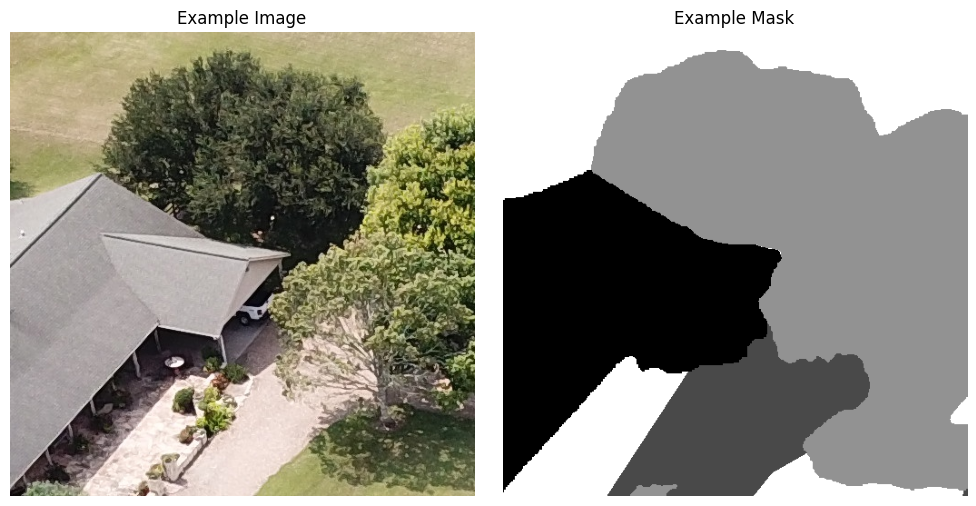

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_images_path = 'train_images.npy'
train_masks_path = 'train_masks.npy'

# Load numpy arrays
train_images = np.load(train_images_path)
train_masks = np.load(train_masks_path)

# Print shapes and types to verify
print(f"Loaded training images shape: {train_images.shape}, dtype: {train_images.dtype}")
print(f"Loaded training masks shape: {train_masks.shape}, dtype: {train_masks.dtype}")

# Choose an example index to visualize
example_index = 200

# Display example image and mask
plt.figure(figsize=(10, 5))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(train_images[example_index])
plt.title('Example Image')
plt.axis('off')

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(train_masks[example_index].squeeze(), cmap='gray')
plt.title('Example Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
val_images_path = 'val_images.npy'
val_masks_path = 'val_masks.npy'

# Load numpy arrays for validation
val_images = np.load(val_images_path)
val_masks = np.load(val_masks_path)

# Print shapes and types to verify
print(f"Loaded validation images shape: {val_images.shape}, dtype: {val_images.dtype}")
print(f"Loaded validation masks shape: {val_masks.shape}, dtype: {val_masks.dtype}")


Loaded validation images shape: (867, 512, 512, 3), dtype: float32
Loaded validation masks shape: (867, 512, 512, 1), dtype: float32


In [ ]:
train_masks = train_masks.astype(np.uint8)
val_masks = val_masks.astype(np.uint8)

In [ ]:
import tensorflow as tf

In [ ]:
train_masks_categorical = tf.keras.utils.to_categorical(train_masks, num_classes=10)
val_masks_categorical = tf.keras.utils.to_categorical(val_masks, num_classes=10)

In [ ]:
train_masks_categorical.shape

(2603, 512, 512, 10)

In [ ]:
val_masks_categorical.shape

(867, 512, 512, 10)

In [ ]:
train_images = train_images *255
val_images = val_images *255

In [ ]:
train_images = train_images.astype(np.uint8)

In [ ]:
val_images = val_images.astype(np.uint8)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import keras.backend as K

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    num_classes = 10
    dice = 0
    for i in range(num_classes):
        dice += dice_coefficient(y_true[:, :, :, i], y_pred[:, :, :, i])
    return 1 - dice / num_classes


In [ ]:
from keras.optimizers import Adam

In [ ]:
input_shape = (512, 512, 3)

inputs = Input(shape=input_shape)

# Preprocess input data for VGG16
preprocessed_inputs = tf.keras.applications.vgg16.preprocess_input(inputs)

# Load the VGG16 model with pre-trained ImageNet weights, without the top fully connected layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=preprocessed_inputs)

#vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg16.layers:
     layer.trainable = False


encoder_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
encoder_output = [vgg16.get_layer(layer_name).output for layer_name in encoder_layers]

# Decoder
# Contracting path (encoder)
inputs = vgg16.input
skips = encoder_output

# Expanding path (decoder)
x = skips[-1]  # Starting point of decoder
for i in range(1, len(skips)):
    x = Conv2DTranspose(512 // (2 ** i), (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([skips[-i-1], x], axis=3)
    x = Conv2D(512 // (2 ** i), (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

# Final convolution layer (output layer)
num_classes = 10
outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

# Create the model
model = Model(inputs=[inputs], outputs=[outputs])
optimizer = tf.keras.optimizers.Adam(
    learning_rate=(1e-4))
# Compile the model
metrics = tf.keras.metrics.OneHotMeanIoU(num_classes=10,ignore_class=0)
model.compile(optimizer=optimizer, loss=dice_loss, metrics=[metrics])

#model.compile(optimizer='adam', loss=loss2, metrics=[m])
#tf.keras.metrics.IoU(num_classes=10,target_class_ids=[1,2,3,4,5])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 512, 512, 3)          0         ['input_2[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_1 (TFOpLamb  (None, 512, 512, 3)          0         ['tf.__operators__.getitem_1[0
 da)                                                                ][0]']                        
                                                                                            

In [ ]:
batch_size = 16
epochs = 2

#Train the model
history = model.fit(
    train_images,
    train_masks_categorical,
    validation_data=(val_images, val_masks_categorical),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training and validation metrics
history_dict = history.history

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict.get('one_hot_mean_iou', []), label='Training IoU')
plt.plot(history_dict.get('val_one_hot_mean_iou', []), label='Validation IoU')
plt.title('Model Accuracy (IoU)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('floodnet_model_dice.h5')